In [23]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

nltk.download('punkt')
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

import torch
import torchtext
from torchtext import data
import os

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
os.chdir("/content/drive/MyDrive/ECE1786/Project")

In [26]:
ls

data/  Final_Project.ipynb  Final_Project_v1.ipynb


# Data Preprocessing

## Load the dataset

Dataset 1: Hate Speech and Offensive Language Dataset

In [27]:
# load dataset
dataset1 = pd.read_csv('data/dataset1.csv')
dataset1_bak = dataset1.copy()
dataset1.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [28]:
# only keep the text and label column
dataset1.drop(dataset1.columns[[0,1,2,3,4]], axis=1, inplace=True)
dataset1

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,2,"you've gone and broke the wrong heart baby, an..."
24780,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,1,youu got wild bitches tellin you lies


In [29]:
# check the number of rows and columns
dataset1.shape

(24783, 2)

In [30]:
# check if there is any null item
dataset1.isnull().sum()

class    0
tweet    0
dtype: int64

In [31]:
# helper function to convert abbreviated form to original form
def convert_to_original(phrase):
  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase

## Data Cleaning

In [32]:
# text data cleaning
def data_processing(text):
  # lower casing
  text = str(text).lower()

  # remove unicode strings
  text = re.sub(r'(\\u[0-9A-Fa-f]+)', r'', text)

  # remove non-ascii characters
  text = re.sub(r'[^\x00-\x7f]', r'', text)

  # remove @user indicaters
  text = re.sub(r'@\w+', r'', text)

  # remove digits
  text = re.sub(r'\d', r'', text)

  # remove '#' symbols inside strings
  text = re.sub(r'#', r'', text)

  # remove urls
  text = re.sub(r'http\S+', r'', text)

  # remove multiple white spaces
  text = re.sub(r'[\s]+', r' ', text)

  # remove multiple break-line with single white space.
  text = re.sub(r'[\n]+', r' ', text)

  # tokenization
  text = nltk.word_tokenize(text)

  # convert abbreviated form to original form
  text = convert_to_original(' '.join(text)).split()

  # remove short strings with length=1 and length=2
  text = [word for word in text if not len(word) in [1,2]]

  # remove non-alphanumeric characters
  text = [word for word in text if word.isalpha()]

  return ' '.join(text)

In [33]:
dataset1['tweet'] = dataset1['tweet'].apply(data_processing)
dataset1

,class,tweet
0,2,woman you should not complain about cleaning y...
1,1,boy dats cold tyga dwn bad for cuffin dat hoe ...
2,1,dawg you ever fuck bitch and she start cry you...
3,1,she look like tranny
4,1,the shit you hear about might true might faker...
...,...,...
24778,1,you muthaf lie right his trash now mine bible ...
24779,2,you have gone and broke the wrong heart baby a...
24780,1,young buck wan eat dat nigguh like aint fuckin...
24781,1,youu got wild bitches tellin you lies


In [34]:
dataset1['tweet'].replace('', np.nan, inplace=True)

In [35]:
dataset1.isnull().sum()

class    0
tweet    9
dtype: int64

In [36]:
dataset1.dropna(subset=['tweet'], inplace=True)

In [37]:
dataset1.isnull().sum()

class    0
tweet    0
dtype: int64

In [38]:
# example before and after data cleaning
print(dataset1_bak['tweet'][0])
print(dataset1['tweet'][0])

!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
woman you should not complain about cleaning your house amp man you should always take the trash out


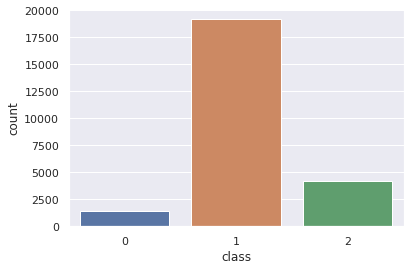

In [39]:
# Before augmentation
sns.set(style="darkgrid")
ax = sns.countplot(x="class", data=dataset1)

In [40]:
# dataset1
dataset1['class'].value_counts(normalize = True)

1    0.774522
2    0.167757
0    0.057722
Name: class, dtype: float64

In [41]:
len_class_0 = dataset1.groupby(['class'])['class'].count()[0]

In [42]:
sample_size = len_class_0
sampled_dataset1 = dataset1.groupby('class').apply(lambda x: x.sample(sample_size))

In [43]:
sampled_dataset1.reset_index(inplace=True, drop=True)

In [44]:
sampled_dataset1

,class,tweet
0,0,cowboys win games during the regular season bu...
1,0,scandal negro bed wench and propaganda via mus...
2,0,fuck those faggots
3,0,you have new boyfriend every week you doin hoe
4,0,lmaoooo what bunch fags
...,...,...
4285,2,charlie sheen slams rihanna for rejecting his ...
4286,2,top layer trash
4287,2,dumb beaner
4288,2,oreo ice cream cake


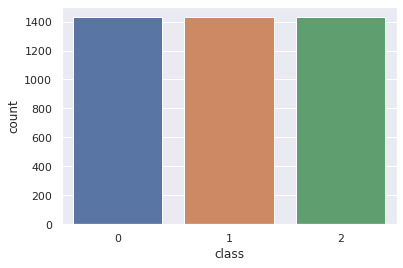

In [45]:
# After data augmentation
sns.set(style="darkgrid")
ax = sns.countplot(x="class", data=sampled_dataset1)

In [46]:
# create train/validation/test splits
predictor = sampled_dataset1.drop("class", axis = "columns")
X_train_val, X_test, y_train_val, y_test = train_test_split(predictor, sampled_dataset1["class"], test_size=0.2, random_state=20, stratify = sampled_dataset1["class"])
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=20, stratify = y_train_val)

train = pd.concat([X_train, y_train], axis=1)
val = pd.concat([X_val, y_val], axis=1)
test = pd.concat([X_test, y_test], axis=1)

train.to_csv("data/train.tsv", sep="\t")
val.to_csv("data/validation.tsv", sep="\t")
test.to_csv("data/test.tsv", sep="\t")

# Prepare the Data for Input
we will use TorchText with our edited Dataset to prepare the model input data

In [47]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, split="train"):
        data_path = "data"
        df = pd.read_csv(os.path.join(data_path, f"{split}.tsv"), sep="\t")

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["tweet"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row["class"])
        self.X = X 
        self.Y = torch.tensor(Y)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx] 
    
# my_collate_function prepares batches
# it also pads each batch with zeroes.

def my_collate_function(batch, device):
    # Handle the padding here
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function 
    # should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device), 
    # we need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

In [48]:
batch_size_num = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100
                                
train_dataset = TextDataset(glove, "train")
val_dataset = TextDataset(glove, "validation")
test_dataset = TextDataset(glove, "test")
    
train_dataloader = torch.utils.data.DataLoader(
  dataset=train_dataset, 
  batch_size=batch_size_num, 
  shuffle=False, 
  collate_fn=lambda batch: my_collate_function(batch, device))

validation_dataloader = torch.utils.data.DataLoader(
  dataset=val_dataset, 
  batch_size=batch_size_num, 
  shuffle=False, 
  collate_fn=lambda batch: my_collate_function(batch, device))

test_dataloader = torch.utils.data.DataLoader(
  dataset=test_dataset,
  batch_size=batch_size_num,
  shuffle=False,
  collate_fn=lambda batch: my_collate_function(batch, device))

# for text, label in train_dataloader:
#   print(text)
#   print(label)

# Define the models & training

## Neural Network Baseline 

In [49]:
# class BaselineModel(torch.nn.Module):
#   def __init__(self, embedding_size, vocab):
#       super().__init__()
#       self.embedding = torch.nn.Embedding.from_pretrained(vocab.vectors)  # embedding layer
#       self.expanding_1 = torch.nn.Linear(embedding_size, 20) # hidden layer 1
#       self.expanding_2 = torch.nn.Linear(20, 3) # hidden layer 2
      
#   def forward(self, x):
#       e = self.embedding(x)
#       output = self.expanding_1(torch.mean(e, 0))
#       output = self.expanding_2(output)

#       return output, e

In [50]:
class BaselineModel(torch.nn.Module):
  def __init__(self, embedding_size, vocab):
      super().__init__()
      self.embedding = torch.nn.Embedding.from_pretrained(vocab.vectors)  # embedding layer
      self.expanding = torch.nn.Linear(embedding_size, 3) # hidden layer
      
  def forward(self, x):
      e = self.embedding(x)
      output = self.expanding(torch.mean(e, 0))
      output = torch.softmax(output, 1)

      return output, e

In [51]:
def train_model(glove, train_dataloader, validation_dataloader, learning_rate, epochs, batch_size):
  embedding_size = 100

  # Instantiate the model & set up the optimizer
  model = BaselineModel(embedding_size, glove)
  criterion = torch.nn.CrossEntropyLoss() # Cross Entropy [0.2 0.7 0.1] [0, 1, 0]
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  train_losses, val_losses, train_acc, val_acc = [], [], [], []

  for epoch in range(epochs):
      train_loss, val_loss, train_acc_count_epoch, val_acc_count_epoch = 0, 0, 0, 0

      for text, label in train_dataloader:
        # forward
        output, e = model(text) 
        loss = criterion(output.squeeze(), label)
        # output = torch.softmax(output, 1)
        output = torch.max(output, 1).indices
        train_acc_count_epoch += torch.sum(output == label).item()
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
      
      mean_train_loss = train_loss / len(train_dataloader)
      mean_train_acc = train_acc_count_epoch / (len(train_dataloader) * batch_size)

      with torch.no_grad():
        for text_val, label_val in validation_dataloader:
          output_val, e_val = model(text_val) 
          loss_val = criterion(output_val.squeeze(), label_val)
          val_loss += loss_val.item()

          output_val = torch.softmax(output_val, 1)
          output_val = torch.max(output_val, 1).indices
          val_acc_count_epoch += torch.sum(output_val == label_val).item()

      mean_val_loss = val_loss / len(validation_dataloader)
      mean_val_acc = val_acc_count_epoch / (len(validation_dataloader) * batch_size)


      print('Epoch: ', epoch, 'train_loss: ', mean_train_loss, 'validation_loss: ', mean_val_loss, 'train_acc: ', mean_train_acc, 'val_acc: ', mean_val_acc)
      train_losses.append(mean_train_loss)
      val_losses.append(mean_val_loss)
      train_acc.append(mean_train_acc)
      val_acc.append(mean_val_acc)


  return model, train_losses, val_losses, train_acc, val_acc
  

In [52]:
ephochs = 50
learning_rate = 1e-4
torch.manual_seed(2) # fix seed

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ("Using device:", device)


model, train_losses, val_losses, train_acc, val_acc = train_model(glove, train_dataloader, validation_dataloader, learning_rate, ephochs, batch_size_num)


Using device: cpu
Epoch:  0 train_loss:  1.1027185757492863 validation_loss:  1.1022553138954694 train_acc:  0.3346656976744186 val_acc:  0.33430232558139533
Epoch:  1 train_loss:  1.1026621086652888 validation_loss:  1.102205334707748 train_acc:  0.3346656976744186 val_acc:  0.33430232558139533
Epoch:  2 train_loss:  1.1026067927826282 validation_loss:  1.1021564228590144 train_acc:  0.3339389534883721 val_acc:  0.33430232558139533
Epoch:  3 train_loss:  1.1025525754274323 validation_loss:  1.1021084702292154 train_acc:  0.3339389534883721 val_acc:  0.33430232558139533
Epoch:  4 train_loss:  1.1024994150150653 validation_loss:  1.1020615211752958 train_acc:  0.33430232558139533 val_acc:  0.33430232558139533
Epoch:  5 train_loss:  1.102447287287823 validation_loss:  1.102015495300293 train_acc:  0.3339389534883721 val_acc:  0.33430232558139533
Epoch:  6 train_loss:  1.1023961936318598 validation_loss:  1.1019703870595887 train_acc:  0.3339389534883721 val_acc:  0.3328488372093023
Epoch

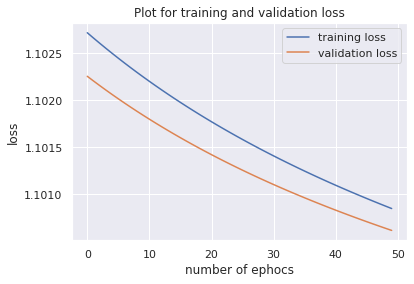

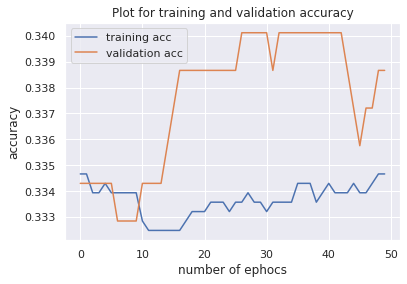

In [53]:
fig = plt.figure()
plt.plot(range(0, ephochs), train_losses, label ='training loss')
plt.plot(range(0, ephochs), val_losses, label ='validation loss')
plt.title("Plot for training and validation loss")
plt.xlabel("number of ephocs")
plt.ylabel("loss")
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(range(0, ephochs), train_acc, label ='training acc')
plt.plot(range(0, ephochs), val_acc, label ='validation acc')
plt.title("Plot for training and validation accuracy")
plt.xlabel("number of ephocs")
plt.ylabel("accuracy")
plt.legend()
plt.show()